In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Scaling if necessity in KNN

In [3]:
df = pd.read_csv('../../DATA/gene_expression.csv')

In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [6]:
len(df)

3000

(4.0, 8.0)

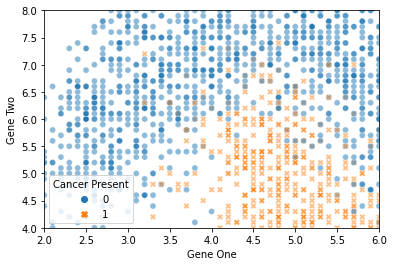

In [12]:
sns.scatterplot(data = df, x = 'Gene One', y = 'Gene Two', hue = 'Cancer Present', alpha = 0.5, style = 'Cancer Present')
plt.xlim(2, 6)
plt.ylim(4, 8)

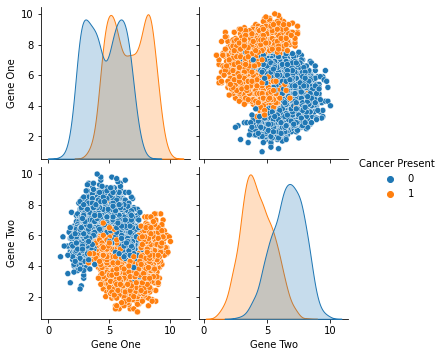

In [13]:
sns.pairplot(df, hue = 'Cancer Present')

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
X = df.drop('Cancer Present', axis = 1)
y = df['Cancer Present']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [17]:
scaler = StandardScaler()

In [23]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [21]:
knn_model = KNeighborsClassifier(n_neighbors = 1)

In [22]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
y_pred = knn_model.predict(scaled_X_test)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
confusion_matrix(y_test, y_pred)

array([[426,  44],
       [ 45, 385]], dtype=int64)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



In [28]:
from sklearn.metrics import accuracy_score

In [30]:
test_error_rates = []
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(scaled_X_train, y_train)

    y_pred_test = knn_model.predict(scaled_X_test)

    test_error = 1 - accuracy_score(y_test, y_pred_test)

    test_error_rates.append(test_error)





## Elbow Method

Text(0, 0.5, 'ERROR RATE')

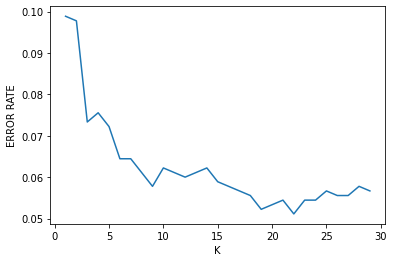

In [32]:
plt.plot(range(1, 30), test_error_rates)
plt.xlabel('K')
plt.ylabel('ERROR RATE')

## Creating a Pipeline

In [33]:
scaler = StandardScaler()

In [36]:
knn = KNeighborsClassifier() # -> use the exactly same key names down below

In [35]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [37]:
operations = [('scaler', scaler), ('knn', knn)]
# (Refernce name we will use later, instance of the class)
# Both should match

In [38]:
from sklearn.pipeline import Pipeline

In [39]:
pipe = Pipeline(operations)

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
k_values = list(range(1, 20))

In [42]:
param_grid = {'n_neigbors' : k_values} # Cannot do this with a pipeline
# Because GridSearch does not know if param grid goes with operation[0] or operation[1]

In [43]:
# choosen_string_name_for_operation + two underscores + parameter_key_name
# Eg = knn__n_neigbors
# choosen_string_name -> Comes from operation
# n_neighbors -> The underscore here has nothing to do with naming convention
param_grid = {'knn__n_neighbors' : k_values}


In [44]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'accuracy')

In [45]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

## Working of the Pipeline

- The pipeline object is quite intelligent
- During CV it will fit only on the K-1 and not on the test data
- Working =>
    - For every value of k the pipeline is run and then CV takes place 

In [46]:
full_cv_classifier.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [48]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [50]:
full_pred = full_cv_classifier.predict(X_test)
# No need to scale as full_cv_classifier is a pipeline

In [51]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [52]:
test = [[3.8, 4]]


In [53]:
full_cv_classifier.predict(test)

c:\Users\Shreyash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [54]:
full_cv_classifier.predict_proba(test)

c:\Users\Shreyash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.1875, 0.8125]])